In [1]:
import wave
import numpy as np
import torch
import os
import glob
from tqdm import tqdm
import sys
import pyaudio
import matplotlib.pyplot as plt

sys.path.append('../')
from espnet2.bin.asr_parallel_transducer_inference import Speech2Text

/mnt/aoni04/yaguchi/anaconda/anaconda3/envs/torch17/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.models.timing.model_baseline import BaselineSystem
from src.utils.utils import load_config

In [3]:
def asr_streaming_decoding(data, is_final=False):
    speech = data.astype(np.float16)/32767.0
    hyps = speech2text.streaming_decode(speech=speech, is_final=is_final)
    if hyps[2] is None:
        results = speech2text.hypotheses_to_results(speech2text.beam_search.sort_nbest(hyps[1]))
    else:
        results = speech2text.hypotheses_to_results(speech2text.beam_search.sort_nbest(hyps[2]))
        
    if results is not None and len(results) > 0 and len(results[0]) > 0:
        text = results[0][0]
        token_int = results[0][2]
    else:
        text = ''
        token_int = [0]
        
    if token_int == []:
        token_int = [0]
        
    return text, token_int

In [4]:
import sflib.sound.sigproc.spec_image as spec_image
generator = spec_image.SpectrogramImageGenerator(
    framesize=800,
    frameshift=160,
    fftsize=1024,
    image_width=10,
    image_height=None,
    image_shift=5
)

In [5]:
"""
speech2text = Speech2Text(
    asr_base_path="/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1",
    asr_train_config="/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1/exp/asr_train_asr_cbs_transducer_848_finetune_raw_jp_char_sp/config.yaml",
    asr_model_file="/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1/exp/asr_train_asr_cbs_transducer_848_finetune_raw_jp_char_sp/valid.loss_transducer.ave_10best.pth",
    token_type=None,
    bpemodel=None,
    beam_search_config={"search_type": "maes"},
    beam_size=3,
    lm_weight=0.0,
    nbest=1,
    #device = "cuda:0", # "cpu",
    device = "cpu",
)
"""
speech2text = Speech2Text(
    asr_base_path="/mnt/aoni04/yaguchi/code/espnet/egs2/atr/asr1",
    asr_train_config="/mnt/aoni04/yaguchi/code/espnet/egs2/atr/asr1/exp/asr_train_asr_cbs_transducer_848_finetune_raw_jp_char_sp/config.yaml",
    asr_model_file="/mnt/aoni04/yaguchi/code/espnet/egs2/atr/asr1/exp/asr_train_asr_cbs_transducer_848_finetune_raw_jp_char_sp/valid.loss_transducer.ave_10best.pth",
    token_type=None,
    bpemodel=None,
    beam_size=5,
    beam_search_config={"search_type": "maes"},
    lm_weight=0.0,
    nbest=1,
    #device = "cuda:0", # "cpu",
    device = "cpu",
)

3steps


In [57]:
# config_path = '../configs/timing/timing_baseline_mla_s1234.json'
config_path = '../configs/timing/annotated_timing_baseline_mla_s1234.json'
config = load_config(config_path)

device = torch.device('cpu')

model = BaselineSystem(config, device)

In [58]:
# baseline
path = "../exp/annotated/data_-500_2000/timing/vad_all/cv1/best_val_loss_model.pth"
# yaguchinoise
# path = "../exp/annotated/data_-500_2000/timing/yaguchinoise/cv1/best_val_loss_model.pth"

model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))#, strict=False)
model.to(device)

BaselineSystem(
  (timing_model): TimingEstimator(
    (lstm): LSTM(384, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=1, bias=True)
    (criterion): BCEWithLogitsLoss()
  )
  (feature_extractor): FeatureExtractor(
    (acoustic_encoder): AcousticEncoder(
      (c1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c2): Conv2d(32, 32, kernel_size=(7, 5), stride=(3, 2), padding=(3, 2))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c3): Conv2d(32, 32, kernel_size=(7, 5), stride=(3, 2), padding=(3, 2))
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c4): Conv2d(32, 32, kernel_size=(7, 5), stride=(3, 2), padding=(3, 2))
      (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lstm): LSTM(320, 512, batch_fi

# File Input

In [59]:
# original, original_mac, yaguchi_mac, yaguchi_iphone
wav_path = '/mnt/aoni04/yaguchi/code/ResponseTimingEstimator_DA/wav/20131101-1_01/20131101-1_01_001_ch0/original.wav'
# wav_path = '/mnt/aoni04/yaguchi/code/ResponseTimingEstimator_DA/wav/20131101-1_01/20131101-1_01_001_ch0/original_silence.wav'
# wav_path = '/mnt/aoni04/yaguchi/code/ResponseTimingEstimator_DA/wav/20131101-1_01/20131101-1_01_001_ch0/yaguchi_iphone.wav'
# wav_path = '/mnt/aoni04/yaguchi/code/ResponseTimingEstimator_DA/wav/20131101-1_01/20131101-1_01_001_ch0/yaguchi_mac.wav'
# wav_path = '/mnt/aoni04/yaguchi/code/ResponseTimingEstimator_DA/wav/20131101-1_01/20131101-1_01_001_ch0/original_mac.wav'

wf = wave.open(wav_path)
wav = np.frombuffer(wf.readframes(wf.getnframes()), np.int16)

In [60]:
import time
# start = time.perf_counter()

chunk_size = 800*2
#chunk_size = 2048
asr_chunk_size = 2048

speech2text.reset_inference_cache()
model.reset_state()

pred_list = []
text_list = []
silence_list = []
vad_list = []
text = ''
pre_text = ''
pre_id = [0]
asr_buffer = np.array([], dtype='int16')
with torch.no_grad():
    for i in range(len(wav)//chunk_size):
        
#         start_o = time.perf_counter()
        
#         start = time.perf_counter()
        wav_chunk = wav[chunk_size*i:chunk_size*(i+1)]

        # ASR : 
        asr_buffer = np.concatenate([asr_buffer, wav_chunk])
        if len(asr_buffer) >= asr_chunk_size:
            asr_chunk = asr_buffer[:asr_chunk_size]
            asr_buffer = asr_buffer[asr_chunk_size:]

            text, token_int = asr_streaming_decoding(asr_chunk)
        else:
            text = pre_text
            token_int = pre_id

        pre_text = text
        pre_id = token_int
        
#         end = time.perf_counter()        
#         print("ASR: {:.5f}".format(end-start))
#         start = time.perf_counter()
        
        # spectrogram
        if i == 0:
            pad = np.zeros(800, np.int16)
            wav_chunk = np.concatenate([pad, wav_chunk])
        result = generator.input_wave(wav_chunk)
        
        
#         end = time.perf_counter()        
#         print("Feature Extraction: {:.5f}".format(end-start))

        # Timing Estimator
        feat = torch.tensor(result).unsqueeze(0).float()
        input_lengths = [1]
        texts = [[text]]
        idxs = [[token_int]]
        indices = [None]

        batch = [feat, input_lengths, texts, idxs, indices, 'test']
        out, silence, vad_out = model.streaming_inference(batch, debug=True) 
        out = torch.sigmoid(out).item()

        pred_list.append(out)
        text_list.append(text)
        silence_list.append(silence)
        vad_list.append(vad_out.item())
        
#         end = time.perf_counter()        
#         print("Timing Estimator: {:.5f}".format(end-start))
        
#         end_o = time.perf_counter()        
#         print("Total: {:.5f}".format(end_o-start_o))
#         print()

In [61]:
vad_list

[0.26517537236213684,
 0.009152322076261044,
 0.9119074940681458,
 0.9135545492172241,
 0.03489828109741211,
 0.9815435409545898,
 0.9945490956306458,
 0.002733960747718811,
 0.9944648146629333,
 0.9276320338249207,
 0.9972435235977173,
 0.04957326874136925,
 0.5150045156478882,
 0.2931816875934601,
 0.98746258020401,
 0.99592125415802,
 0.9978609681129456,
 0.9891157746315002,
 0.019063130021095276,
 0.353493869304657,
 0.948540210723877,
 0.9788974523544312,
 0.9946537017822266,
 0.985808789730072,
 0.3790634870529175,
 0.9944897890090942,
 0.8236635327339172,
 0.9656228423118591,
 0.9490670561790466,
 0.014663861133158207,
 0.9121211171150208,
 0.7376876473426819,
 0.6996073126792908,
 0.007396521046757698,
 0.2720017433166504,
 0.004424355924129486,
 0.00820609088987112,
 0.002990449545904994,
 0.8462228775024414,
 0.008406726643443108,
 0.05760456249117851,
 0.0067205787636339664,
 0.0043573626317083836,
 0.013565805740654469,
 0.004367202054709196,
 0.033813878893852234,
 0.00438

In [62]:
silence_list

[tensor([[[0.7348, 0.0000, 1.0000]]]),
 tensor([[[1.7257, 0.0000, 2.0000]]]),
 tensor([[[1.8138, 1.0000, 3.0000]]]),
 tensor([[[1.9002, 2.0000, 4.0000]]]),
 tensor([[[2.8653, 0.0000, 5.0000]]]),
 tensor([[[2.8838, 1.0000, 6.0000]]]),
 tensor([[[2.8892, 2.0000, 7.0000]]]),
 tensor([[[3.8865, 0.0000, 8.0000]]]),
 tensor([[[3.8920, 1.0000, 9.0000]]]),
 tensor([[[ 3.9644,  2.0000, 10.0000]]]),
 tensor([[[ 3.9671,  3.0000, 11.0000]]]),
 tensor([[[ 4.9176,  0.0000, 12.0000]]]),
 tensor([[[ 5.4026,  1.0000, 13.0000]]]),
 tensor([[[ 6.1094,  0.0000, 14.0000]]]),
 tensor([[[ 6.1219,  1.0000, 15.0000]]]),
 tensor([[[ 6.1260,  2.0000, 16.0000]]]),
 tensor([[[ 6.1281,  3.0000, 17.0000]]]),
 tensor([[[ 6.1390,  4.0000, 18.0000]]]),
 tensor([[[ 7.1200,  0.0000, 19.0000]]]),
 tensor([[[ 7.7665,  0.0000, 20.0000]]]),
 tensor([[[ 7.8179,  1.0000, 21.0000]]]),
 tensor([[[ 7.8390,  2.0000, 22.0000]]]),
 tensor([[[ 7.8444,  3.0000, 23.0000]]]),
 tensor([[[ 7.8586,  4.0000, 24.0000]]]),
 tensor([[[ 8.4795,

(0.0, 1.0)

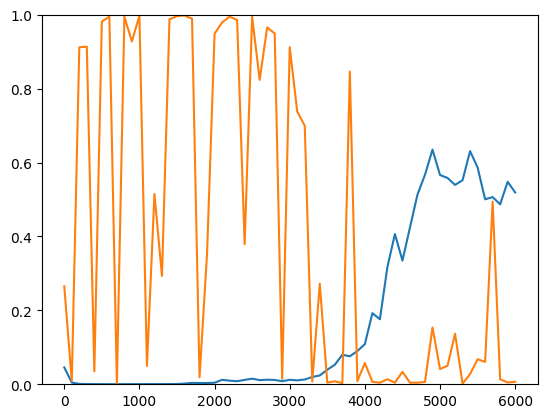

In [63]:
import matplotlib.pyplot as plt

t = [i * 100 for i in range(len(pred_list))]
plt.plot(t, pred_list)
plt.plot(t, vad_list)
plt.ylim(0.0, 1.0)

In [64]:
text_list

['',
 '',
 '',
 '',
 '',
 '',
 '',
 'えーと二',
 'えーと日本',
 'えーと日本',
 'えーと日暮里',
 'えーと日暮里の',
 'えーと日暮里のち',
 'えーと日暮里のち',
 'えーと日暮里の近',
 'えーと日暮里の近く',
 'えーと日暮里の近くで',
 'えーと日暮里の近くで何',
 'えーと日暮里の近くで何',
 'えーと日暮里の近くで何か',
 'えーと日暮里の近くで何か',
 'えーと日暮里の近くで何かい',
 'えーと日暮里の近くで何かい',
 'えーと日暮里の近くで何かいい',
 'えーと日暮里の近くで何かいいみ',
 'えーと日暮里の近くで何かいい店',
 'えーと日暮里の近くで何かいい店あ',
 'えーと日暮里の近くで何かいい店あ',
 'えーと日暮里の近くで何かいい店あり',
 'えーと日暮里の近くで何かいい店ありま',
 'えーと日暮里の近くで何かいい店あります',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 'えーと日暮里の近くで何かいい店ありますかね',
 

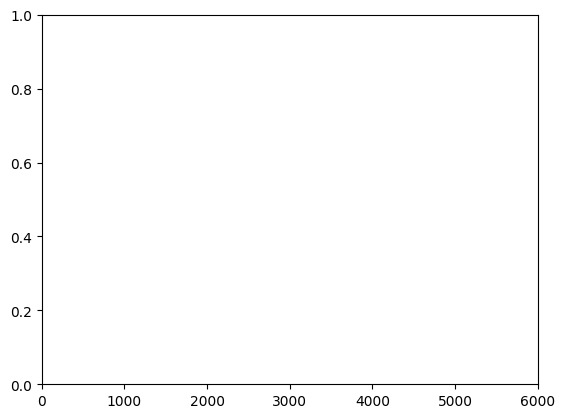

In [65]:
from matplotlib.animation import FuncAnimation

t = [i * 100 for i in range(len(pred_list))]

# プロットの初期設定
fig, ax = plt.subplots()
ax.set_xlim(0, max(t))
ax.set_ylim(0, 1)
line, = ax.plot([], [], lw=2)

# 初期化関数
def init():
    line.set_data([], [])
    return line,

# アニメーション関数
def animate(i):
    x = t[:i+1]
    y = pred_list[:i+1]
    line.set_data(x, y)
    return line,

# アニメーションの設定
ani = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=True)

# 動画として保存
#ani.save('animation.mp4', writer='ffmpeg')

# グラフ表示
plt.show()


# Microphone Input

In [ ]:
CHUNK=1600
ASR_CHUNK=2048

FORMAT=pyaudio.paInt16
CHANNELS=1
RATE=16000
RECORD_SECONDS=7
p=pyaudio.PyAudio()
stream = p.open(format=FORMAT,channels=CHANNELS,rate=RATE,input=True,frames_per_buffer=CHUNK)

cnnae.reset_generator()
speech2text.reset_inference_cache()
model.reset_state()

pred_list = []
text_list = []
vad_list = []
frames = []
text = ''
pre_text = ''
pre_id = 0
asr_buffer = np.array([], dtype='int16')
for i in range(0,int(RATE/CHUNK*RECORD_SECONDS)+1):        

    data=stream.read(CHUNK)
    data=np.frombuffer(data, dtype='int16')
    frames.append(data)
    #data=data.astype(np.float16)/32767.0 #32767 is the upper limit of 16-bit binary numbers and is used for the normalization of int to float.

    with torch.no_grad():
        asr_buffer = np.concatenate([asr_buffer, data])
        if len(asr_buffer) >= ASR_CHUNK:
            asr_chunk = asr_buffer[:ASR_CHUNK]
            asr_buffer = asr_buffer[ASR_CHUNK:]

            text, token_int = asr_streaming_decoding(asr_chunk)
            progress_output(text)
        else:
            text = pre_text
            token_int = pre_id
            progress_output(text)
            
        pre_text = text
        pre_id = token_int

        # CNN-AE
        if i == 0:
            pad = np.zeros(1440, np.int16)
            data = np.concatenate([pad, data])

        feature, _ = cnnae(data, streaming=True)    

        # Timing Estimator
        feat = torch.tensor(feature.reshape(1, 1, 128))
        input_lengths = [1]
        texts = [[text]]
        idxs = [[token_int]] 
        indices = [None]

        batch = [feat, input_lengths, texts, idxs, indices, 'test']
        out, silence, vad_out = model.streaming_inference(batch, debug=True) 
        out = torch.sigmoid(out).item()
        out = torch.sigmoid(out).item()

        pred_list.append(out)
        text_list.append(text)
        vad_list.append(vad_out)
        
stream.stop_stream()
stream.close()
p.terminate()